## Лабораторная 7: логические алгоритмы. Бустинг

### Попробуем применить самые сильные на сегодняшний день композиции логических алгоритмов к рассмотренной в лабораторной работе 3 задаче о Титанике. Загрузите данные и подключите необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn import *
from imblearn.over_sampling import RandomOverSampler
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,7

In [4]:
data = pd.read_csv('online_shoppers_intention.csv');
data.describe(include='all')

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330,12330.000000,12330.000000,12330.000000,12330.000000,12330,12330,12330
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,3,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,May,NaN,NaN,NaN,NaN,Returning_Visitor,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3364,NaN,NaN,NaN,NaN,10551,9462,10422
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,NaN,2.124006,2.357097,3.147364,4.069586,NaN,NaN,NaN
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,NaN,0.911325,1.717277,2.401591,4.025169,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,NaN,2.000000,2.000000,1.000000,2.000000,NaN,NaN,NaN
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,NaN,2.000000,2.000000,3.000000,2.000000,NaN,NaN,NaN
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,NaN,3.000000,2.000000,4.000000,4.000000,NaN,NaN,NaN


In [5]:
data['Month']

0        Feb
1        Feb
2        Feb
3        Feb
4        Feb
        ... 
12325    Dec
12326    Nov
12327    Nov
12328    Nov
12329    Nov
Name: Month, Length: 12330, dtype: object

## 2

### Закодируйте номинальные признаки числовыми значениями:

In [6]:
columns = ['Revenue','Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues','SpecialDay' ]
data1 = data.loc[:, columns].copy(deep=True).reset_index(drop=True)
columns = ['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues','SpecialDay' ]
# Тут мы все числовые(или номинальные) признаки нормализуем (-1,1)
from sklearn.preprocessing import StandardScaler
features = data1[columns]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
data1[columns] = features

# Бинаризуем целевой признак, то есть False = 0, True = 1

le = preprocessing.LabelEncoder()
data1['Revenue'] = le.fit_transform(data1['Revenue'])
data1
# One hot encoding для всех категориальных признаков(выведи таблицу и сам поймёшь как это работает)
data1 = data1.join(pd.get_dummies(data.OperatingSystems, prefix='opsys'))
data1 = data1.join(pd.get_dummies(data.Browser, prefix='browser'))
data1 = data1.join(pd.get_dummies(data.Region, prefix='region'))
data1 = data1.join(pd.get_dummies(data.TrafficType, prefix='traficT'))
data1 = data1.join(pd.get_dummies(data.VisitorType, prefix='visitT'))
data1 = data1.join(pd.get_dummies(data.Weekend, prefix='weekend'))
data1 = data1.join(pd.get_dummies(data.Month, prefix='month'))

# Ниже закоментированный код, ни на что не влият, это я когда изменял код, не хотел удалять старый
#print(features.mean(axis = 0))
#data1.loc[data1.Revenue == 0]
#le = preprocessing.LabelEncoder()
#

In [7]:
# (это тоже не нужный код)генератор разбиений обучающей выборки на train и test
#cv = model_selection.KFold(n_splits=3, shuffle=True, random_state=0)

# Здесь разбиваем DataSet на 30% для test, 70% для train

data_train = data1.loc[0.3*data1.shape[0]:1.0*data1.shape[0]]
data_test = data1.loc[0.0*data1.shape[0]:0.3*data1.shape[0]]

ros = RandomOverSampler(random_state=0)
X_train = data_train.loc[:,data_train.columns != 'Revenue'].values
Y_train = data_train['Revenue'].values
# Oversampling train(70% Dataset) Для баланса между true и false целевого признака Revenue
X_overs_train, Y_overs_train = ros.fit_sample(X_train, Y_train)
# к test oversampling не применяем 
X_test = data_test.loc[:,data_test.columns != 'Revenue'].values
Y_test = data_test['Revenue'].values
#X_overs_test, Y_overs_test = ros.fit_sample(X_test, Y_test)

In [8]:
# Проверяем сбалансированость датасета

from collections import Counter
print(sorted(Counter(Y_train).items()))
print(sorted(Counter(Y_overs_train).items()))

[(0, 7090), (1, 1541)]
[(0, 7090), (1, 7090)]


In [9]:
# Здесь предсказания для несбалансированного X_train, Y_train

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    Tree = tree.DecisionTreeClassifier(max_depth=5.9, criterion='entropy')
    #prediction = model_selection.cross_val_predict(Tree, X_oversampled, Y_oversampled, )
    Tree.fit(X_train, Y_train)
    pr = Tree.predict(X_test)
    acc = metrics.accuracy_score(Y_test, pr)
    print('Tree: {:6.4}'.format(acc))

    RandomForest = ensemble.RandomForestClassifier()
    RandomForest.fit(X_train, Y_train)
    pr = RandomForest.predict(X_test)
    acc = metrics.accuracy_score(Y_test, pr)
    print('RandomForest: {:6.4}'.format(acc))

    XGBoost = xgb.XGBClassifier()
    XGBoost.fit(X_train, Y_train)
    pr = XGBoost.predict(X_test)
    acc = metrics.accuracy_score(Y_test, pr)
    print('XGBoost: {:6.4}'.format(acc))

    LightGBM = lgb.LGBMClassifier(verbosity=-1)
    LightGBM.fit(X_train, Y_train)
    pr = LightGBM.predict(X_test)
    acc = metrics.accuracy_score(Y_test, pr)
    print('LightGBM: {:6.4}'.format(acc))

    CatBoost = CatBoostClassifier(logging_level='Silent', learning_rate=0.00015)
    CatBoost.fit(X_train, Y_train)
    pr = CatBoost.predict(X_test)
    acc = metrics.accuracy_score(Y_test, pr)
    print('CatBoost: {:6.4}'.format(acc))

Tree: 0.9368
RandomForest: 0.9408
XGBoost: 0.9422
LightGBM: 0.9419
CatBoost: 0.9457


In [10]:
# Здесь предсказания для сбалансированного X_train, Y_train(overs это сокращение oversamling

X1 = X_overs_train; Y1 = Y_overs_train
X2 = X_test; Y2 = Y_test
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    Tree = tree.DecisionTreeClassifier(max_depth=5.9, criterion='entropy')
    #prediction = model_selection.cross_val_predict(Tree, X_oversampled, Y_oversampled, )
    Tree.fit(X1, Y1)
    pr = Tree.predict(X2)
    acc = metrics.accuracy_score(Y2, pr)
    print('Tree: {:6.4}'.format(acc))

    RandomForest = ensemble.RandomForestClassifier()
    RandomForest.fit(X1, Y1)
    pr = RandomForest.predict(X2)
    acc = metrics.accuracy_score(Y2, pr)
    print('RandomForest: {:6.4}'.format(acc))

    XGBoost = xgb.XGBClassifier()
    XGBoost.fit(X1, Y1)
    pr = XGBoost.predict(X2)
    acc = metrics.accuracy_score(Y2, pr)
    print('XGBoost: {:6.4}'.format(acc))

    LightGBM = lgb.LGBMClassifier(verbosity=-3)
    LightGBM.fit(X1, Y1)
    pr = LightGBM.predict(X2)
    acc = metrics.accuracy_score(Y2, pr)
    print('LightGBM: {:6.4}'.format(acc))

    CatBoost = CatBoostClassifier(logging_level='Silent', learning_rate=0.00015)
    CatBoost.fit(X1, Y1)
    pr = CatBoost.predict(X2)
    acc = metrics.accuracy_score(Y2, pr)
    print('CatBoost: {:6.4}'.format(acc))

Tree: 0.9259
RandomForest: 0.9443
XGBoost: 0.9416
LightGBM: 0.9376
CatBoost: 0.9257


## 4

### В комментариях попытайтесь объяснить парадокс, почему перечисленные выше супер алгоритмы не смогли победить метод ближайших соседей из 3-й лабораторной работы?

In [ ]:
#В 3 лабораторной работе произошло переобучение, так как коэффиценты подбирались в ручную,
#соответственно результаты не правдоподобны
#А в этой лабораторной и без подбора результат был хорошим(>80%)

##  5
### Найдите 10 самых информативных признаков, при помощи следующего подхода. Используйте по очереди каждый признак, чтобы по нему предсказать ответ. Нарисуйте на графике столбцовую диаграмму качества предсказаний

In [49]:
method = lgb.LGBMClassifier(verbosity=-1)
# важность признаков
importance = {}
for c in data1.columns:
    if c == 'Revenue': continue
    # пытаемся предсказать результат, используя только один столбец
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prediction = model_selection.cross_val_predict(method, 
                                                       data1[c].values.reshape(-1,1),
                                                       data1['Revenue'],
                                                       cv=cv)
    importance[c] = metrics.accuracy_score(data1['Revenue'], prediction)
cols = list(importance.keys())
fi = np.array([importance[c] for c in cols])

NameError: name 'cv' is not defined

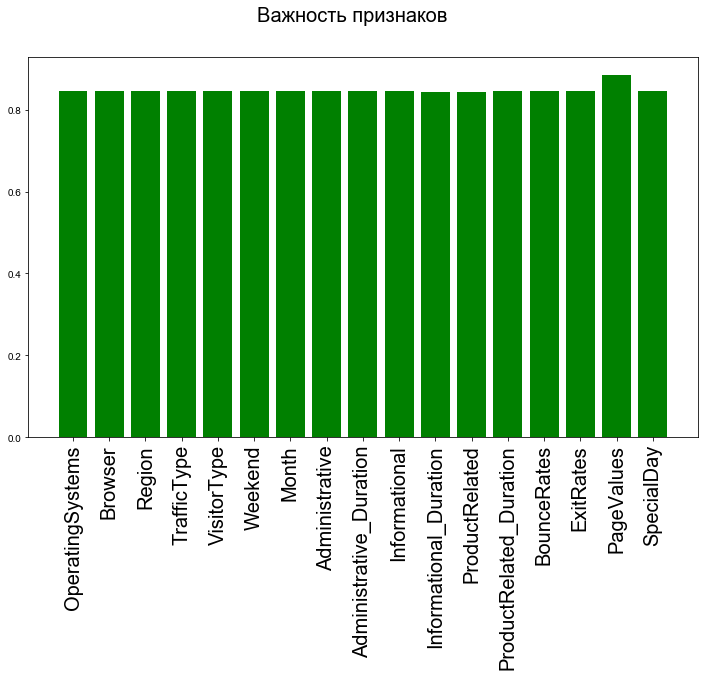

In [83]:
fig = plt.figure()
plt.rc('font', family='Arial')
plt.rcParams['xtick.labelsize'] = 20
plt.bar(np.arange(len(cols)), fi, color='g')
plt.xticks(np.arange(len(cols)), cols, rotation='vertical')
_ = fig.suptitle('Важность признаков', fontsize=20)

## 6
### Судя по графику самыми важными являются признаки пола и приставки к имени. Переберите все возможные пары признаков и выясните, является ли эта пара признаков наилучшей. Выведите на экран 10 лучших пар по убывнию их важности

In [80]:
method = lgb.LGBMClassifier(verbosity=-1)
# важность признаков
importance = {}
used_cols = []
for c in data1.columns:
    if c == 'Revenue': continue
    used_cols.append(c)
    for d in data1.columns:
    # пытаемся предсказать результат, используя только один столбец
        if d == 'Revenue' or d==c or d in used_cols: continue
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            prediction = model_selection.cross_val_predict(method, 
                                                       data1.loc[:,[c, d]].values,
                                                       data1['Revenue'],
                                                       cv=cv)
        importance[c + ' ' + d] = metrics.accuracy_score(data1['Revenue'], prediction)
cols = list(importance.keys())
fi = np.array([importance[c] for c in cols])

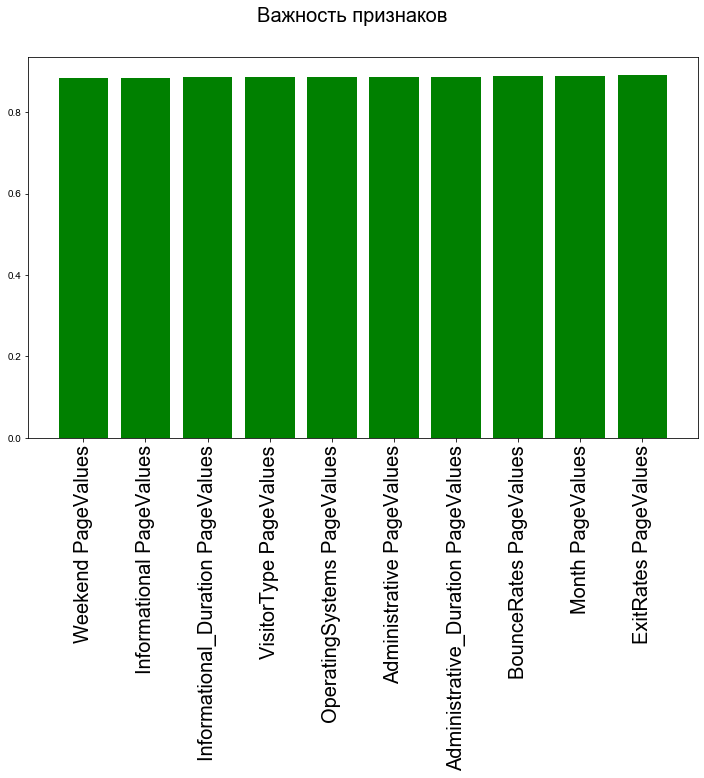

In [81]:
ind = np.argsort(fi)
fi = fi[ind]
cols = np.array(cols)[ind]
fig = plt.figure()
plt.rc('font', family='Arial')
plt.rcParams['xtick.labelsize'] = 20
plt.bar(np.arange(len(cols[-10:])), fi[-10:], color='g')
plt.xticks(np.arange(len(cols[-10:])), cols[-10:], rotation='vertical')
_ = fig.suptitle('Важность признаков', fontsize=20)